In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("Data/project_adult.csv", encoding='utf-8')

In [3]:
df_valid = pd.read_csv("Data/project_validation_inputs.csv", encoding='utf-8')

In [4]:
# process and standardize data
# This is not an all inclusive function....you should improve!
def preprocess_data(df):

    # Handle missing values by replacing '?' with NaN and dropping rows
    for col in df.columns:
        df[col] = df[col].replace('?', pd.NA)


    df = df.dropna()

    # Drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # split off target early (if present)
    y = None
    if 'income' in df.columns:
        y = df['income']
        df = df.drop(columns=['income'])

    if y is not None:
        le = LabelEncoder()
        y = le.fit_transform(y).astype(int)  # encode target as int

    # detect numeric vs categorical by attempted coercion
    numeric_cols, categorical_cols = [], []
    for col in df.columns:
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().all():
            df[col] = coerced.astype(float)   # numeric as float
            numeric_cols.append(col)
        else:
            df[col] = df[col].astype(str)     # categorical as string
            categorical_cols.append(col)

    # label-encode categoricals only
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype(int)  # encoded as int
        label_encoders[col] = le

    # standardize numeric columns only
    scaler = StandardScaler()
    if numeric_cols:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols].astype(float)).astype(float)

    # Encode categorical features
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le


    # Make X and y arrays
    X = df.values.astype(float)
    if y is not None:
        y = y.astype(int)

    return X, y

In [5]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [6]:
# preprocess data with created function
X, y = preprocess_data(df)

In [7]:
# split data into training and test datasets
# can specify same proportion of classes in both sets with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
# Initialize the model with default parameters.
# For multi-class problems, LogisticRegression uses a one-vs-rest strategy by default.
# The 'solver' is set to 'lbfgs' as it's a good default for multi-class problems.
model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
model.fit(X_train, y_train.ravel())

LogisticRegression(max_iter=200, random_state=42)

In [9]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
# np.logspace(-4,4,20) tells GridSearchCV to test 20 values for C eenly spaced on logarithmic scale from 10^-4 to 10^4
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
}

# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, max_iter=2000),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.ravel())
# Print the best cross-validation score achieved during GridSearchCV
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best cross-validation score: 0.8221



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 0.03359818286283781}
Best cross-validation accuracy: 0.8221

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8156

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4538
           1       0.71      0.44      0.54      1502

    accuracy                           0.82      6040
   macro avg       0.77      0.69      0.71      6040
weighted avg       0.80      0.82      0.80      6040


Confusion Matrix:
[[4263  275]
 [ 839  663]]


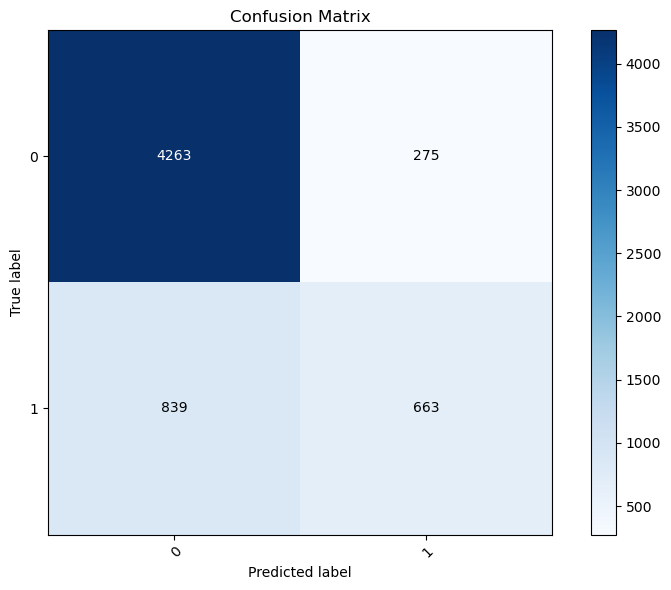

In [10]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [11]:
# Make predictions on the validation dataset using the best GridSearchCV model
X_valid, y_valid = preprocess_data(df_valid)  # No target variable in validation set

y_valid_pred = best_model.predict(X_valid)

# Convert to a df and save to csv
df_valid_pred = pd.DataFrame(y_valid_pred, columns=['Predicted_Income'])
df_valid_pred.to_csv("Data/validation_predictions/Group_8_LogisticRegression_PredictedOutputs.csv", index=False)